In [411]:
%reset
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")
import torch
import numpy as np
import defmod as dm
import multimodule_usefulfunctions as mm 
import matplotlib.pyplot as plt

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [412]:
nb_pts1 = 10
nb_pts2 = 7
dim = 2

o1 = torch.tensor([1,1]).float()
o2 = torch.tensor([5,5]).float()
origin = [o1,o2]
radius = [2,1]
numberPoints = [nb_pts1, nb_pts2]
gd_list = mm.multipleCircles(origin, radius, numberPoints)

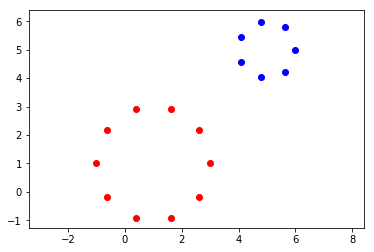

In [413]:
plt.scatter(gd_list[0][:, 0].detach().numpy(), gd_list[0][:, 1].detach().numpy(), c='red')
plt.scatter(gd_list[1][:, 0].detach().numpy(), gd_list[1][:, 1].detach().numpy(), c='blue')

plt.axis('equal')
plt.show()

In [414]:
# Defining the deformation modules
sigma1 = 10
manifold1 = dm.manifold.Landmarks(dim, nb_pts1, gd=gd_list[0].view(-1))
trans1 = dm.deformationmodules.Translations(manifold1, sigma1)

sigma2 = 10
manifold2 = dm.manifold.Landmarks(dim, nb_pts2, gd=gd_list[1].view(-1))
trans2 = dm.deformationmodules.Translations(manifold2, sigma2)

module_list = [trans1, trans2]
sigma_bg = 0.1
modules = dm.multishape.MultiShapeModule(module_list, sigma_bg)


In [415]:
# Setting cotangent variables
p1 = torch.cat([10*torch.ones(nb_pts1,1, requires_grad=True), torch.zeros(nb_pts1,1)],1).view(-1)
p2 = torch.cat([-10*torch.ones(nb_pts2,1,requires_grad=True), torch.zeros(nb_pts2,1)],1).view(-1)
cotan2 = [p1, p2, [p1, p2]]
cotan = [torch.rand(nb_pts1*dim, requires_grad=True), torch.rand(nb_pts2*dim, requires_grad=True), [torch.rand((nb_pts1)*dim, requires_grad=True),torch.rand((nb_pts2)*dim, requires_grad=True)]]
modules.manifold.fill_cotan(cotan2)



In [416]:
constr_Id = dm.constraints.Identity()
l, h = modules.compute_geodesic_variables( constr_Id)

In [417]:
import defmod.hamiltonian_multishape as hamiltonian
H = hamiltonian.Hamiltonian_multi(modules, constr_Id)

In [442]:
# Check derivative of Hamiltonian wrt controls is zero
def controlslist2tensor(controls_list):
    return torch.cat([controls_list[0].view(-1),controls_list[1].view(-1), controls_list[-1][0].view(-1),controls_list[-1][1].view(-1)])

def controlstensor2list(controls, nb_pts, dim):
    n = sum(nb_pts)
    return [controls[:dim*nb_pts[0]], controls[dim*nb_pts[0]:dim*(nb_pts[0]+nb_pts[1])], [controls[dim*n:dim*(n+nb_pts[0])], controls[dim*(n+nb_pts[0]):]]]


def Hamiltonian(controls):
    #modules.controls = controlstensor2list(controls, numberPoints, dim)
    modules.fill_controls(controls)
    H = hamiltonian.Hamiltonian_multi(modules, constr_Id)
    return H()


controls = dm.usefulfunctions.flatten_tensor_list(modules.controls, [])


a = torch.autograd.grad(Hamiltonian(modules.controls), controls, retain_graph=True)

[sum(torch.abs(ai)) for ai in a]

[tensor(4.2325), tensor(1.3494), tensor(4.7814e-06), tensor(2.8617e-06)]

In [419]:
#H.geodesic_controls()

In [420]:
def applymom(l):
    H.module.manifold[0].fill_cotan(l[0])
    H.module.manifold[1].fill_cotan(l[1])
    H.module.manifold[2].fill_cotan([l[2], l[3]])
    H.geodesic_controls()
    
    return sum([H.module.manifold.manifold_list[i].inner_prod_field(H.module[i].field_generator()) for i in range(3)])

In [421]:
def Hamiltonian_p(cotan):
    
    cotan = controlstensor2list(cotan, [nb_pts1, nb_pts2], dim)
    #H.module.manifold.fill_cotan(cotan)
    
    H.module.manifold[0].fill_cotan(cotan[0])
    H.module.manifold[1].fill_cotan(cotan[1])
    H.module.manifold[2].fill_cotan(cotan[2])
    
    H.geodesic_controls()
    return H()

In [422]:
cotan = controlslist2tensor(H.module.manifold.cotan)
deltaH = torch.autograd.grad(Hamiltonian_p(cotan), cotan, create_graph=True)

In [423]:
def Hamiltonian(l):
    H.module.manifold[0].fill_cotan(l[0])
    H.module.manifold[1].fill_cotan(l[1])
    H.module.manifold[2].fill_cotan([l[2], l[3]])
    H.geodesic_controls()
    return H()

In [424]:
def costterm(l):
    H.module.manifold[0].fill_cotan(l[0])
    H.module.manifold[1].fill_cotan(l[1])
    H.module.manifold[2].fill_cotan([l[2], l[3]])
    H.geodesic_controls()
    return sum([H.module[i].cost() for i in range(3)])

In [425]:
def constraintsterm(l):
    H.module.manifold[0].fill_cotan(l[0])
    H.module.manifold[1].fill_cotan(l[1])
    H.module.manifold[2].fill_cotan([l[2], l[3]])
    H.geodesic_controls()
    return H.apply_constr()

In [426]:
def controlslist2tensor(controls_list):
    return torch.cat([modules.controls[0].view(-1,1),modules.controls[1].view(-1,1), modules.controls[-1][0].view(-1,1),modules.controls[-1][1].view(-1,1)])


def geodesiccontrols(l):
    H.module.manifold[0].fill_cotan(l[0])
    H.module.manifold[1].fill_cotan(l[1])
    H.module.manifold[2].fill_cotan([l[2], l[3]])    
    H.geodesic_controls()

    return controlslist2tensor(H.module.controls)



In [427]:
cotan = [*H.module.manifold.unroll_cotan()]

deltaapplymom = torch.autograd.grad(applymom(cotan), cotan, create_graph=True)
#deltaH = torch.autograd.grad(Hamiltonian(cotan), [cotan[0], cotan[1], cotan[2], cotan[3]], create_graph=True)
deltacost = torch.autograd.grad(costterm(cotan), [cotan[0], cotan[1], cotan[2], cotan[3]], create_graph=True)
deltaconstr = torch.autograd.grad(constraintsterm(cotan), [cotan[0], cotan[1], cotan[2], cotan[3]], create_graph=True)


In [434]:
#print(deltaH)

In [435]:
#print(deltaapplymom)

In [436]:
#print(deltacost)

In [437]:
#print(deltaconstr)

In [438]:
# action 
speed_action = [gdi.action(modulei).tan for gdi, modulei in zip(H.module.manifold.manifold_list, H.module)] 

#print(speed_action)
H.module.manifold.fill_tan(speed_action)

In [440]:
manifold_t, controls_t = dm.shooting.shoot_euler(H, it=10)

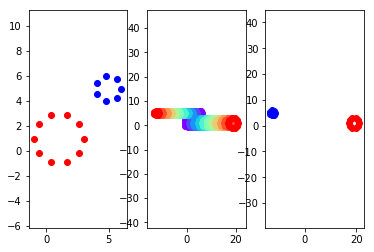

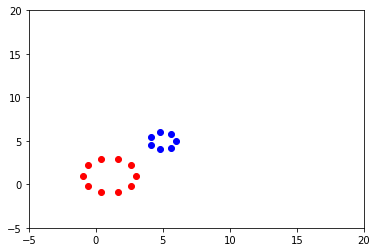

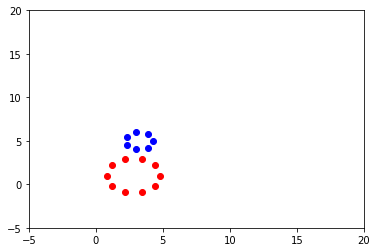

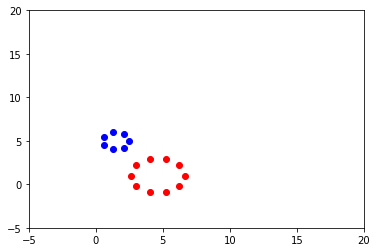

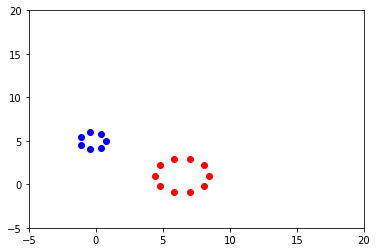

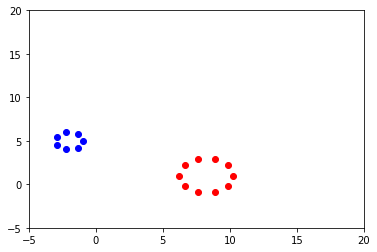

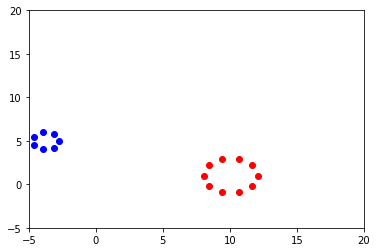

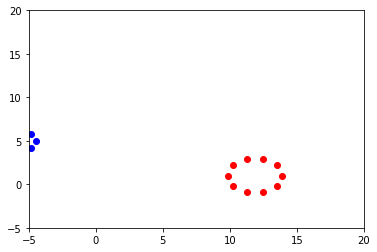

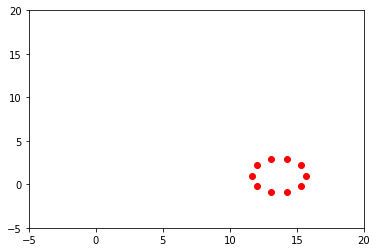

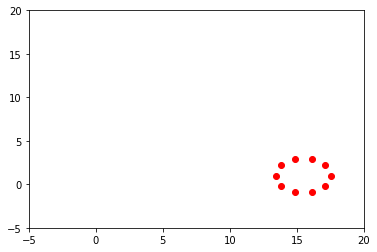

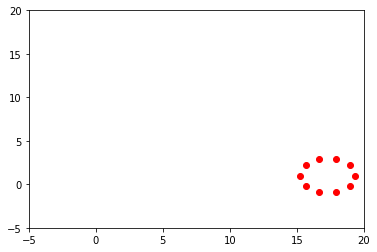

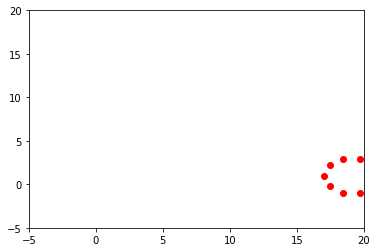

In [441]:
import matplotlib.cm as cm

gd_t = [man.gd for man in manifold_t]

# Geometrical descriptors at initial time
plt.subplot(1,3,1)
plt.scatter(gd_list[0][:, 0].detach().numpy(), gd_list[0][:, 1].detach().numpy(), c='red')
plt.scatter(gd_list[1][:, 0].detach().numpy(), gd_list[1][:, 1].detach().numpy(), c='blue')
plt.axis('equal')

# Geometrical Descriptors transported over time by shooting
plt.subplot(1,3,2)
colors = cm.rainbow(np.linspace(0, 1, len(gd_t)))
for i,c in zip(range(len(gd_t)), colors):
    plt.scatter(gd_t[i][0].view(-1,dim)[:,0].detach().numpy(), gd_t[i][0].view(-1,dim)[:, 1].detach().numpy(), color=c)
    plt.scatter(gd_t[i][1].view(-1,dim)[:,0].detach().numpy(), gd_t[i][1].view(-1,dim)[:, 1].detach().numpy(), color=c)
plt.axis('equal')

# Geometrical descriptors at final time
plt.subplot(1,3,3)
plt.scatter(gd_t[-1][0].view(-1,dim)[:, 0].detach().numpy(), gd_t[-1][0].view(-1,dim)[:, 1].detach().numpy(), c='red')
plt.scatter(gd_t[-1][1].view(-1,dim)[:, 0].detach().numpy(), gd_t[-1][1].view(-1,dim)[:, 1].detach().numpy(), c='blue')
plt.axis('equal')



for i in range(len(gd_t)):
    plt.figure()
    plt.scatter(gd_t[i][0].view(-1,dim)[:, 0].detach().numpy(), gd_t[i][0].view(-1,dim)[:, 1].detach().numpy(), c='red')
    plt.scatter(gd_t[i][1].view(-1,dim)[:, 0].detach().numpy(), gd_t[i][1].view(-1,dim)[:, 1].detach().numpy(), c='blue')
    plt.axis([-5,20,-5,20])

plt.show()